![konya](ktun.png)
<h4><center>T.C.<br>KONYA TEKNİK ÜNİVERSİTESİ<br>LİSANSÜSTÜ EĞİTİM ENSTİTÜSÜ</center><h4>

<strong><center>Dental X-ray Image Analysis</center></strong>
<strong><center>Cephalometric Keypoints Detection using CNN Run</center></strong><br>

# Automated Detection and Analysis for Diagnosis in Cephalometric X-ray Image Using Convolutional Neural Network

This project is build on top of the Wang Cwei dataset which can be found in the
link: https://figshare.com/s/37ec464af8e81ae6ebbf <br>


### The scope of this work is to read the images and display the dots annotated by a professional medical doctor

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from skimage import io, transform, img_as_float
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.datasets as dsets
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms, models # add models to the list
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import models
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.utils import make_grid
import time
import random

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

*Lets perfom this operation on one image and sclale before performing a similar operation on multiple images*

In [8]:
# Take a look at one of the image samples and labels

#NOTE: THE IMAGE FOLDERS HAS BEEN MODIFIED AND SEPERATED INTO TRAIN AND TEST FOLDERS SETS
SAMPLE_PATH = "../data/RawImage/TrainingData/005.bmp"
TXT_PATH = "../data/AnnotationsByMD/400_senior/005.txt"
# import sample image
img = io.imread(SAMPLE_PATH, as_gray=True)
img

array([[0.94509804, 0.94509804, 0.94509804, ..., 0.94901961, 0.94117647,
        0.00392157],
       [0.94509804, 0.94509804, 0.94509804, ..., 0.94901961, 0.94117647,
        0.00392157],
       [0.94509804, 0.94509804, 0.94509804, ..., 0.94901961, 0.94117647,
        0.00392157],
       ...,
       [0.94117647, 0.94117647, 0.94117647, ..., 0.89803922, 0.89411765,
        0.        ],
       [0.94509804, 0.94509804, 0.94509804, ..., 0.90588235, 0.90980392,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00784314, 0.        ,
        0.01176471]])

In [9]:
img.shape

(2400, 1935)

In [10]:
# import sample coordinates from text as tuples
def extract_labels_from_txt(path):
    with open(path, "r") as f:
        # only first 19 are actual coords in dataset label files
        coords_raw = f.readlines()[:19]
        coords_raw = [tuple([int(float(s)) for s in t.split(",")]) for t in coords_raw]
        return coords_raw

In [11]:
coords_raw = extract_labels_from_txt(TXT_PATH)
coords_raw

[(705, 1026),
 (1294, 823),
 (1243, 1085),
 (529, 1223),
 (1423, 1445),
 (1334, 1780),
 (1324, 1964),
 (1278, 2010),
 (1309, 1993),
 (717, 1657),
 (1414, 1607),
 (1459, 1633),
 (1542, 1471),
 (1505, 1762),
 (1470, 1376),
 (1380, 2001),
 (949, 1365),
 (1380, 1311),
 (629, 1323)]

In [1]:
plt.rcParams["figure.figsize"] = [32,18]
plt.style.use(['dark_background'])
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 1, 1)
ax1.imshow(img, cmap="gray")
# also plot resized image for later 
orig_y, orig_x = img.shape[:2]
SCALE = 15

# for rescale, use same target for both x&y axis
rescaled_img = transform.resize(img,(orig_y/SCALE,orig_y/SCALE))
ax2.imshow(rescaled_img, cmap="gray")

for c in coords_raw:
    # add patches to original image
    # could also just plt.scatter() but less control then
    ax1.add_patch(plt.Circle(c, 5, color='r')) 
    # and rescaled marks to resized images
    x,y = c
    x = int(x*(orig_y*1.0/orig_x)/SCALE)
    y = int(y/SCALE)
    ax2.add_patch(plt.Circle((y,x), 1, color='g')) 

plt.show()

NameError: name 'plt' is not defined

In [96]:
def print_image(img,labels):
    print(img.shape)
    plt.rcParams["figure.figsize"] = [32,18]
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 1, 1)
    ax1.imshow(img, cmap="gray")
    # also plot resized image for later 
    orig_y, orig_x = img.shape[:2]
    SCALE = 15
    
    # for rescale, use same target for both x&y axis
    rescaled_img = transform.resize(img,(orig_y/SCALE,orig_y/SCALE))
    ax2.imshow(rescaled_img, cmap="gray")
    
    
    for c in coords_raw:
        # add patches to original image
        # could also just plt.scatter() but less control then
        ax1.add_patch(plt.Circle(c, 5, color='r')) 
        # and rescaled marks to resized images
        x,y = c
        x = int(x*(orig_y*1.0/orig_x)/SCALE)
        y = int(y/SCALE)
        ax2.add_patch(plt.Circle((x,y), 1, color='g')) 

    plt.show()

[[1.         1.         1.         ... 0.99607843 1.         0.        ]
 [1.         1.         1.         ... 0.99607843 1.         0.        ]
 [1.         1.         1.         ... 0.99607843 1.         0.        ]
 ...
 [1.         1.         1.         ... 0.87058824 0.88235294 0.        ]
 [1.         1.         1.         ... 0.89411765 0.87058824 0.        ]
 [0.         0.         0.         ... 0.         0.01176471 0.        ]]
(2400, 1935)


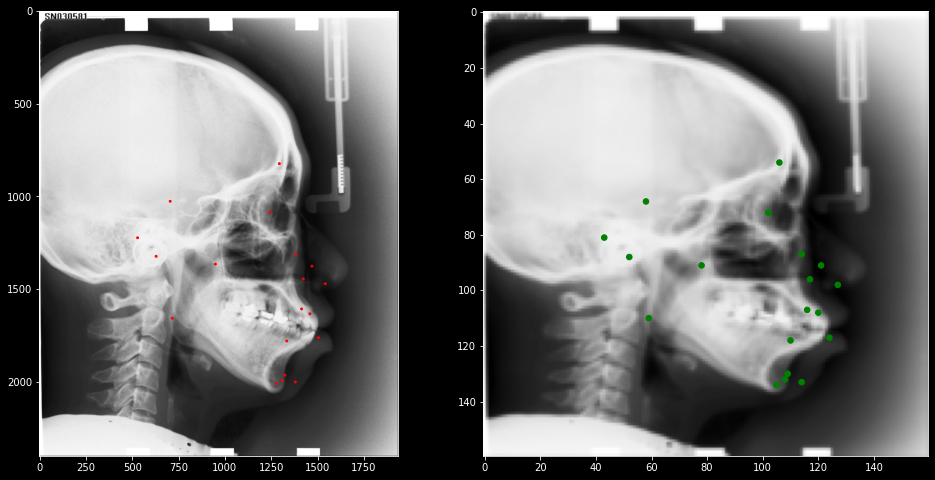

[[0.06666667 0.06666667 0.0627451  ... 0.95686275 0.95686275 0.        ]
 [0.0627451  0.0627451  0.05882353 ... 0.95686275 0.95686275 0.        ]
 [0.05490196 0.05490196 0.05098039 ... 0.95686275 0.95686275 0.        ]
 ...
 [0.95686275 0.95686275 0.95686275 ... 0.94509804 0.95294118 0.        ]
 [0.95686275 0.95686275 0.95686275 ... 0.96078431 0.96078431 0.00392157]
 [0.         0.         0.         ... 0.01176471 0.         0.00784314]]
(2400, 1935)


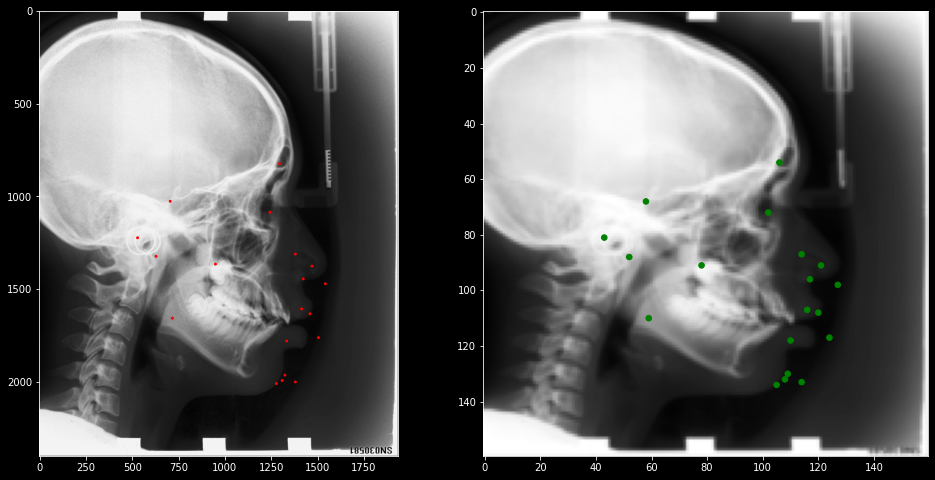

[[0.99607843 0.99607843 0.99607843 ... 0.99607843 1.         0.        ]
 [0.99607843 0.99607843 0.99607843 ... 0.99607843 1.         0.        ]
 [0.99607843 0.99607843 0.99215686 ... 0.99607843 1.         0.        ]
 ...
 [1.         1.         1.         ... 0.34509804 0.41960784 0.        ]
 [1.         1.         1.         ... 0.39215686 0.44705882 0.01176471]
 [0.         0.         0.         ... 0.01568627 0.         0.        ]]
(2400, 1935)


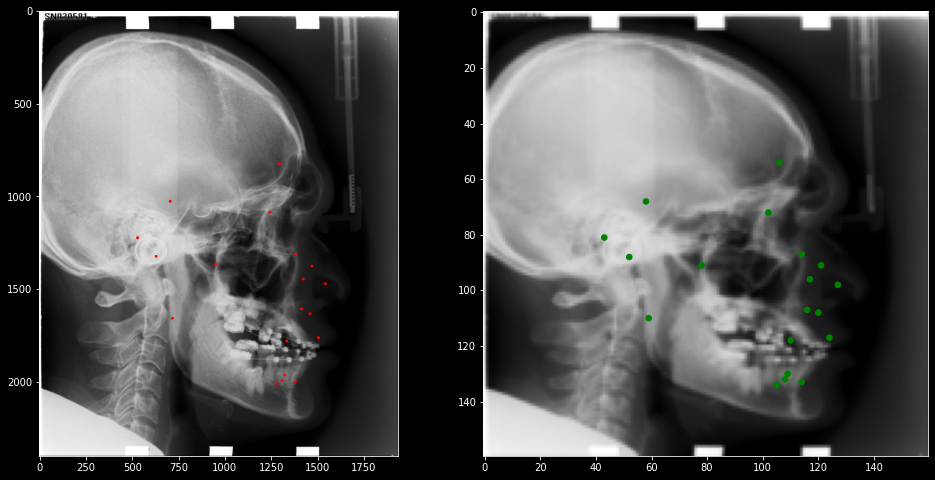

[[1.         1.         1.         ... 0.99607843 1.         0.        ]
 [1.         1.         1.         ... 0.99607843 1.         0.        ]
 [1.         1.         1.         ... 0.99607843 1.         0.        ]
 ...
 [1.         1.         1.         ... 0.96078431 0.96078431 0.        ]
 [1.         1.         1.         ... 0.98823529 0.98823529 0.01568627]
 [0.         0.         0.         ... 0.00784314 0.         0.00392157]]
(2400, 1935)


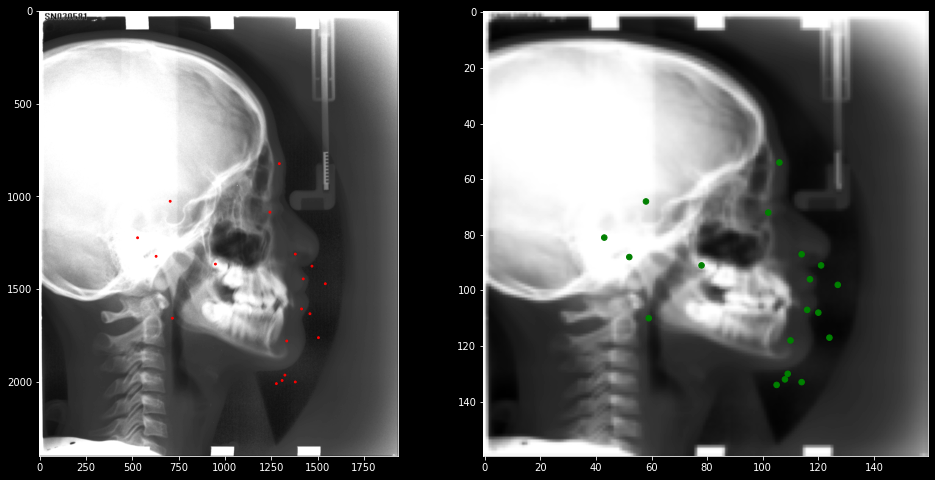

[[1.         1.         1.         ... 0.99607843 1.         0.        ]
 [1.         1.         1.         ... 0.99607843 1.         0.        ]
 [1.         1.         1.         ... 0.99607843 1.         0.        ]
 ...
 [1.         1.         1.         ... 0.97647059 1.         0.01960784]
 [1.         1.         1.         ... 1.         0.97254902 0.        ]
 [0.         0.         0.         ... 0.         0.02352941 0.        ]]
(2400, 1935)


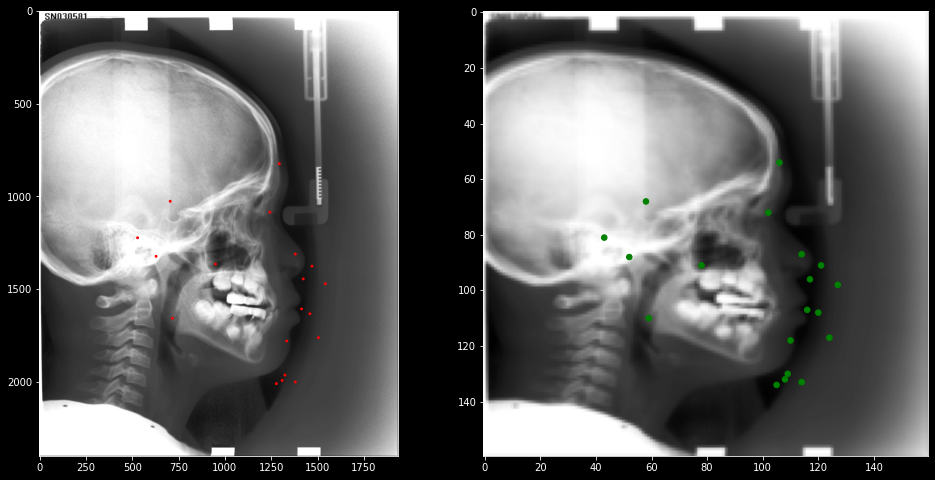

[[0.99607843 0.99607843 0.99607843 ... 0.99607843 0.99607843 0.00392157]
 [0.99607843 0.99607843 0.99607843 ... 0.99607843 0.99607843 0.00392157]
 [0.99607843 0.99607843 0.99607843 ... 0.99607843 0.99607843 0.00392157]
 ...
 [0.99607843 0.99607843 0.99607843 ... 0.75294118 0.77647059 0.        ]
 [0.99607843 0.99607843 0.99607843 ... 0.72156863 0.74509804 0.00392157]
 [0.         0.         0.         ... 0.         0.         0.01960784]]
(2400, 1935)


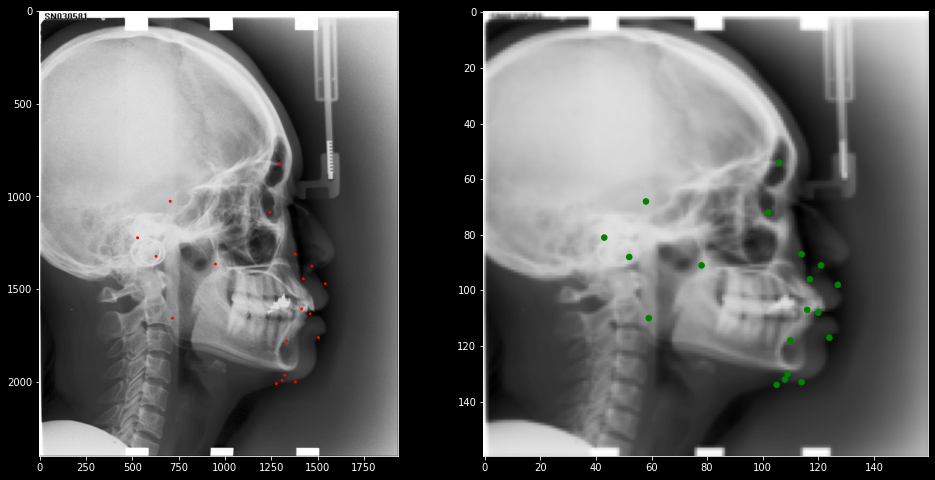

[[0.11372549 0.11372549 0.11372549 ... 0.67843137 0.6745098  0.00392157]
 [0.11372549 0.11372549 0.11372549 ... 0.67843137 0.6745098  0.00392157]
 [0.11372549 0.11372549 0.11372549 ... 0.67843137 0.6745098  0.00392157]
 ...
 [0.67843137 0.67843137 0.67843137 ... 0.67843137 0.69803922 0.        ]
 [0.67058824 0.67058824 0.67058824 ... 0.68235294 0.67058824 0.01568627]
 [0.00392157 0.00392157 0.00392157 ... 0.         0.         0.        ]]
(2400, 1935)


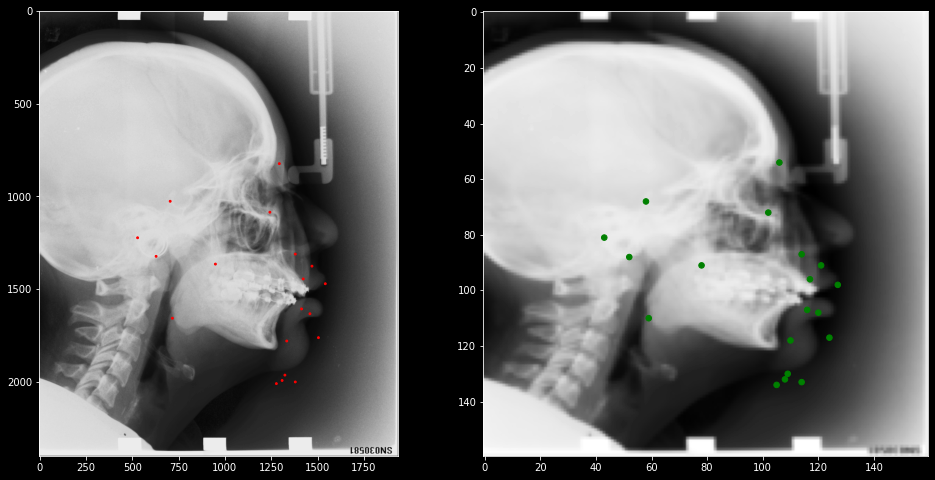

[[0.96862745 0.96862745 0.96862745 ... 0.97254902 0.96470588 0.        ]
 [0.96862745 0.96862745 0.96862745 ... 0.97254902 0.96470588 0.        ]
 [0.96862745 0.96862745 0.96862745 ... 0.97254902 0.96470588 0.        ]
 ...
 [0.97254902 0.97254902 0.97254902 ... 0.88235294 0.89019608 0.        ]
 [0.96862745 0.96862745 0.96862745 ... 0.89019608 0.89803922 0.        ]
 [0.         0.         0.         ... 0.         0.         0.01176471]]
(2400, 1935)


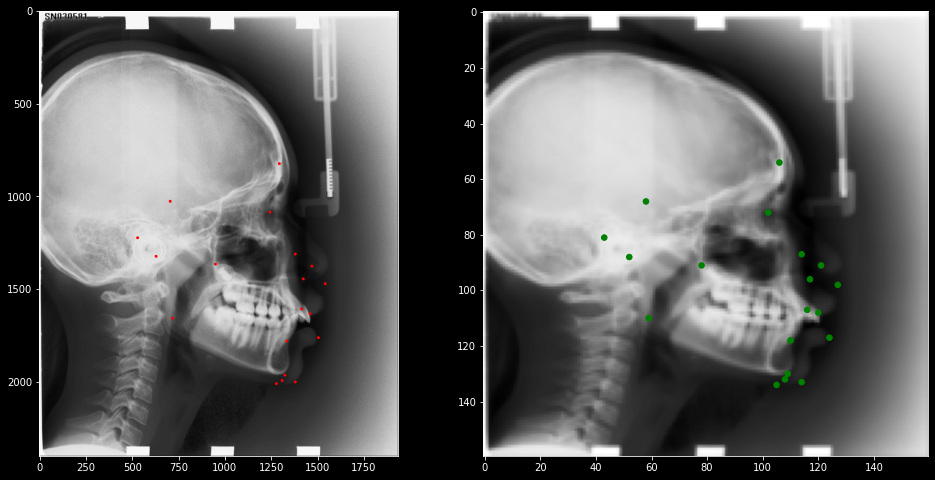

[[0.98039216 0.98039216 0.98039216 ... 0.98039216 0.98431373 0.        ]
 [0.98039216 0.98039216 0.98039216 ... 0.98039216 0.98431373 0.        ]
 [0.98039216 0.98039216 0.98039216 ... 0.98039216 0.98431373 0.        ]
 ...
 [0.97647059 0.97647059 0.97647059 ... 0.43137255 0.45490196 0.        ]
 [0.98039216 0.98039216 0.98039216 ... 0.44313725 0.40784314 0.05098039]
 [0.         0.         0.         ... 0.         0.02745098 0.        ]]
(2400, 1935)


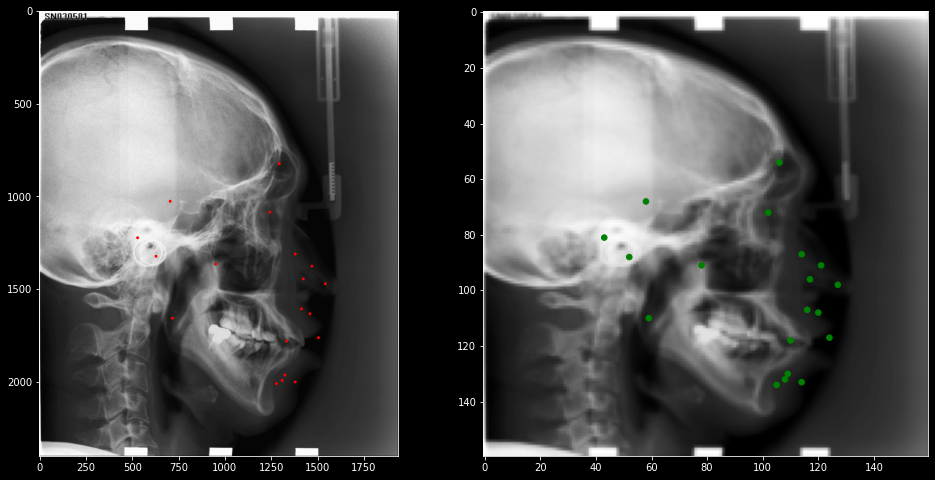

[[0.99607843 0.99607843 0.99607843 ... 0.99607843 0.99607843 0.00392157]
 [0.99607843 0.99607843 0.99607843 ... 0.99607843 0.99607843 0.00392157]
 [0.99607843 0.99607843 0.99607843 ... 0.99607843 0.99607843 0.00392157]
 ...
 [0.99607843 0.99607843 0.99607843 ... 0.77254902 0.84313725 0.        ]
 [0.99607843 0.99607843 0.99607843 ... 0.83921569 0.81960784 0.00392157]
 [0.         0.         0.         ... 0.         0.01568627 0.00784314]]
(2400, 1935)


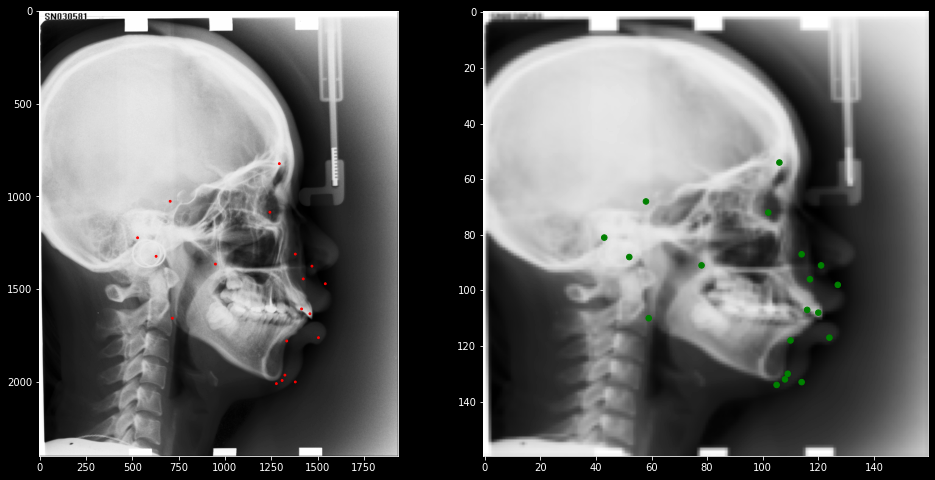

In [98]:
BASE_IMAGE_PATH='data/RawImage/Train/TrainingData/'
BASE_CORD_PATH='data/AnnotationsByMD/400_senior/'

def display_image_and_cord(image_number,img_path, cord_path):
    data = []
    target = []
    for i, fi in enumerate(os.listdir(img_path)):
           if i<image_number:
                loop_img = io.imread(img_path + fi, as_gray=True)
                lf = fi[:-4] + ".txt"
                loop_labels = extract_labels_from_txt(cord_path + lf)
               
                loop_labels = (np.array(loop_labels))
                print(loop_img)
                print_image(loop_img,loop_labels)
           
        

display_image_and_cord(10,BASE_IMAGE_PATH, BASE_CORD_PATH)

## Define transforms
In the previous section we looked at a variety of transforms available for data augmentation (rotate, flip, etc.) and normalization.<br>
Here we'll combine the ones we want, including the <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>recommended normalization parameters</a> for mean and std per channel.

In [99]:
train_transform = transforms.Compose([
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [100]:
root = 'data/RawImage/'

train_data = datasets.ImageFolder(os.path.join(root, 'Train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'Test'), transform=test_transform)



In [101]:
train_data

Dataset ImageFolder
    Number of datapoints: 150
    Root location: data/RawImage/Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [102]:
test_data

Dataset ImageFolder
    Number of datapoints: 250
    Root location: data/RawImage/Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [103]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

In [104]:
class_names = test_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['Test1Data', 'Test2Data']
Training images available: 150
Testing images available:  250


## Display a batch of images
To verify that the training loader selects cat and dog images at random, let's show a batch of loaded images.<br>
Recall that imshow clips pixel values <0, so the resulting display lacks contrast. We'll apply a quick inverse transform to the input tensor so that images show their "true" colors.

In [105]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

In [106]:
images

tensor([[[[ 2.2489,  2.2318,  0.4508,  ...,  2.0263,  2.0605,  1.7523],
          [ 2.2489,  2.1975,  0.3481,  ...,  2.0263,  2.0434,  1.7352],
          [ 2.2489,  2.1804,  0.1768,  ...,  2.0092,  2.0605,  1.7694],
          ...,
          [ 2.1804, -0.3541, -1.9467,  ...,  0.9132,  0.9988,  0.8447],
          [ 2.1975, -0.2856, -1.9295,  ...,  0.9646,  1.0159,  0.8276],
          [ 2.1975, -0.1999, -1.8953,  ...,  0.9646,  1.0673,  0.8961]],

         [[ 2.4286,  2.4111,  0.5903,  ...,  2.2010,  2.2360,  1.9209],
          [ 2.4286,  2.3761,  0.4853,  ...,  2.2010,  2.2185,  1.9034],
          [ 2.4286,  2.3585,  0.3102,  ...,  2.1835,  2.2360,  1.9384],
          ...,
          [ 2.3585, -0.2325, -1.8606,  ...,  1.0630,  1.1506,  0.9930],
          [ 2.3761, -0.1625, -1.8431,  ...,  1.1155,  1.1681,  0.9755],
          [ 2.3761, -0.0749, -1.8081,  ...,  1.1155,  1.2206,  1.0455]],

         [[ 2.6400,  2.6226,  0.8099,  ...,  2.4134,  2.4483,  2.1346],
          [ 2.6400,  2.5877,  

In [107]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

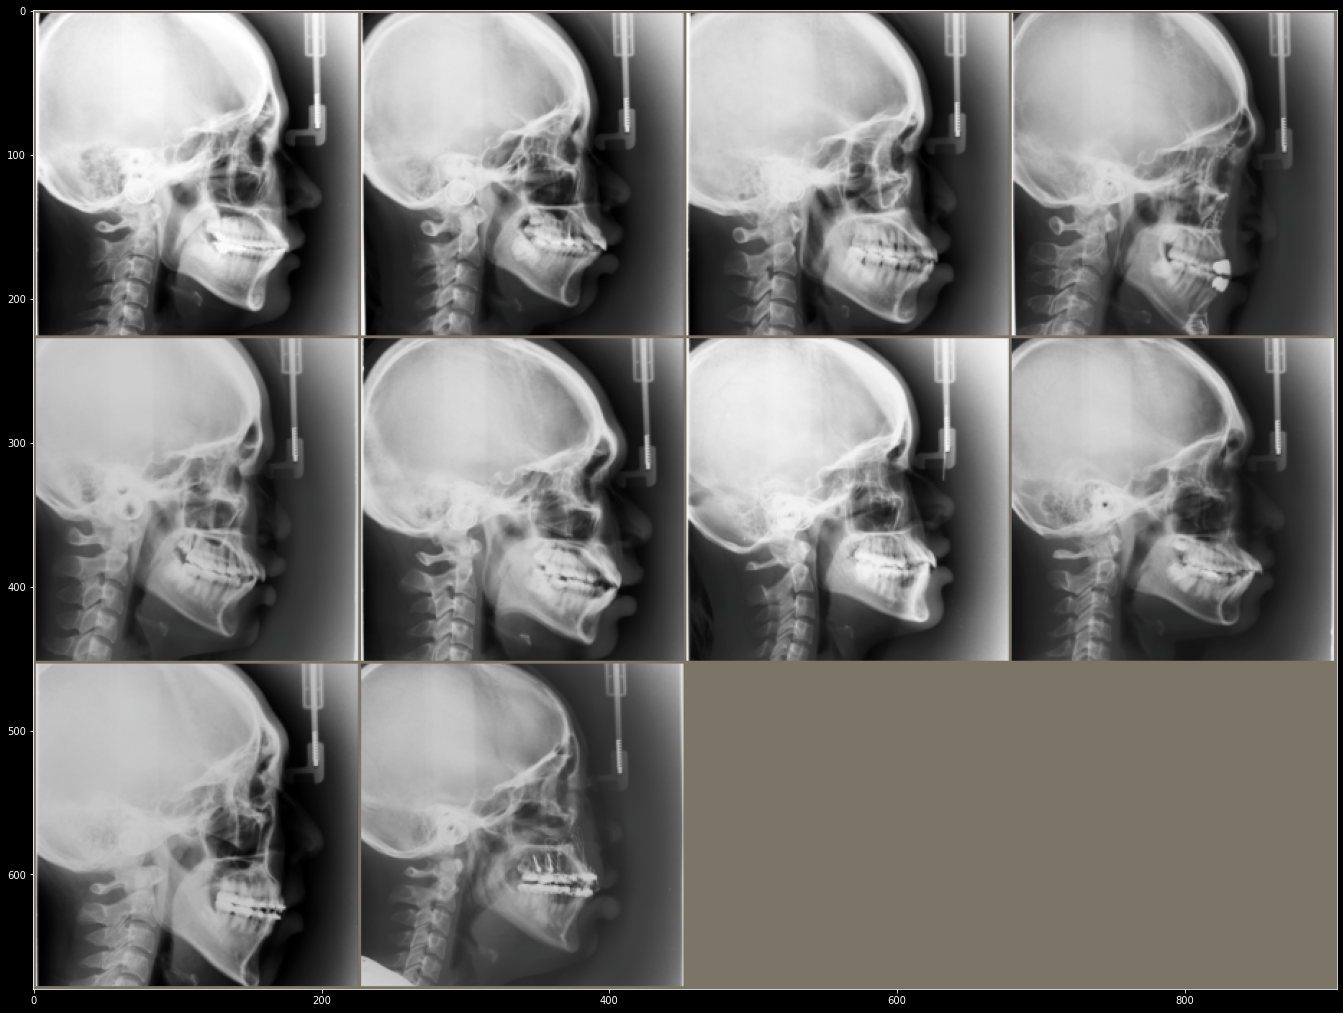

In [108]:
# Print the labels
im = make_grid(images, nrow=4)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(32,18))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));